This notebook walks through using a fairly straightforward ensemble learning approach (boosted regression trees) to estimate parameters 
of an underlying demographic process model using the Site Frequency Spectrum (SFS). The SFS is a common summary of genomic variation that
takes the form of a histogram of allele frequencies. Basically, the first entry tells you how many variants were seen in a single individual,
the second entry tells you how many were seen in two individuals, and so on. As a result, the SFS has at most 2n-1 entries, where n
is the number of diploid individuals you have sampled from a population. There are two flavors of SFS, the unfolded (which relies on
identifying an 'ancestral' variant at each locus, and counts the frequency of the derived variant) and the folded (which counts the 
frequency of the minor allele, i.e., the less frequnty variant). Since the folded SFS can only consider allele's that are present in less than half the sample, there can only be 1/2n non-zero entries. For the current project, I restricted my simulations in msprime (see the sims script for a breakdown of how those work) to the folded SFS, since it can be calculated even when the ancestral allele cannot be identified.

The next cell imports numpy, pandas, and various tools from scikit-lear for model fitting and cross-validation. 

In [30]:
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from sklearn import tree
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Here I read in the csv of parameters from our simulations. These act as our target/response variables in the MultiOutputRegressor we are
going to be fitting. This file also contains the file-paths for the SFS files, which we will use as our predictors in the model. This cell
loops through each file name in n_20 path (the paths for files when we sample 20 individuals), reads the corresponding file in, and appends
to a list of SFS. The result is a list where each entry is the SFS for a given simulation.

In [7]:
big_test = pd.read_csv('/Users/aaronw/Desktop/Dissertation/Chapter_5_Diascia/DL_popgen/Detectability_tests/Shared_data_repo/Benchmarking/Empirical_run/Marginal_locus_run/2e_n20_marginal_params.csv')
x_dat = []
for f in big_test['n20_path']: x_dat.append(pd.read_csv(f)['SFS'])

This cell converts our SFS list to a data frame and then adds the number of simulated loci as the final entry in the SFS. Since these are folded, the final entry (and many more before it) are all zeroes, so it is easy to add this in without losing information. Since many population genomics studies vary in the total number of loci that they sequence, I have varied the number of loci that are simulated. The goal is to sort of 'marginalize' over the number of loci as a nuisance parameter, to see if the model can learn how demographic parameters shape the SFS regardless of the number of sites observed. Hence why I attach it here as a predictor.

In [8]:
x_df = pd.DataFrame(x_dat)
x_df[40] = big_test['num_loci'].values
x_df.head

<bound method NDFrame.head of       0       1      2      3      4      5      6      7      8      9   ...  \
SFS  0.0   491.5  240.5  172.0  105.5   93.5   88.5   72.5   58.5   57.0  ...   
SFS  0.0  1647.0  839.0  601.5  421.0  360.0  301.5  270.5  234.0  221.0  ...   
SFS  0.0  1063.5  520.5  355.5  283.5  215.0  197.5  159.5  147.5  133.5  ...   
SFS  0.0   495.0  255.5  192.5  127.5  113.5   78.5   83.0   76.0   71.5  ...   
SFS  0.0   259.0  132.0   87.0   65.0   60.0   41.5   44.5   22.0   27.5  ...   
..   ...     ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
SFS  0.0    66.5   45.0   43.0   34.0   31.0   35.0   30.0   41.0   41.0  ...   
SFS  0.0  1602.0  768.0  528.0  356.5  316.0  241.5  205.0  196.0  174.0  ...   
SFS  0.0   451.5  263.0  197.0  132.5  125.5   97.0  101.0   70.5   85.5  ...   
SFS  0.0   362.0  196.0  135.5  130.0  115.0   86.5   68.0   77.0   48.5  ...   
SFS  0.0   172.0  115.0  113.0  104.0  119.5   89.0  101.5   86.5   93.0  ...  

The next cell separates out the three parameters that define the two-epoch model: ancestral population size, modern population size, and the time of demographic change. I then define a set of values to scale these parameters. These values are just the midpoint of the prior for each parameter in the simulations. 

In [9]:
y_dat = big_test[['t_change', 'ancestral_size', 'modern_size']]
scale_vals = [2*250250,250250,250250]

In [10]:
scaled_y = y_dat/scale_vals

Here we create our train and test data for both the SFS (x_df) and demographic parameters (scaled_y).

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_df, scaled_y)

Here is an initial fit for a Gradient Boosted Regressor. The next few cells walk through evaluating the test MSE of the model as well as plotting predicted values against true values for training and test data.

In [12]:
params = {'n_estimators': 5000, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5
         }
reg_tree_boost = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params))
reg_tree_boost.fit(x_train,y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=4,
                                                         min_samples_leaf=5,
                                                         min_samples_split=5,
                                                         n_estimators=5000))

In [14]:
mse_train = mean_squared_error(y_train, reg_tree_boost.predict(x_train))
print("The mean squared error (MSE) on training set: {:.4f}".format(mse_train))
mse_test = mean_squared_error(y_test, reg_tree_boost.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_test))

The mean squared error (MSE) on training set: 0.0028
The mean squared error (MSE) on test set: 0.1506


As you can see, we have much poorer performance on our test data than our training data just based on our uniform average MSE (we'll look at raw values for each input later). Let's walk through some plots to see how the model predictions align with the parameter values that generated our simulated data. For all of these plots, the x axis shows the 'true' values from the simulation and the y axis shows the value predicted by the model.

In [83]:
x_train_preds = reg_tree_boost.predict(x_train)
x_test_preds = reg_tree_boost.predict(x_test)
train_pred_df = pd.DataFrame(x_train_preds)
test_pred_df = pd.DataFrame(x_test_preds)

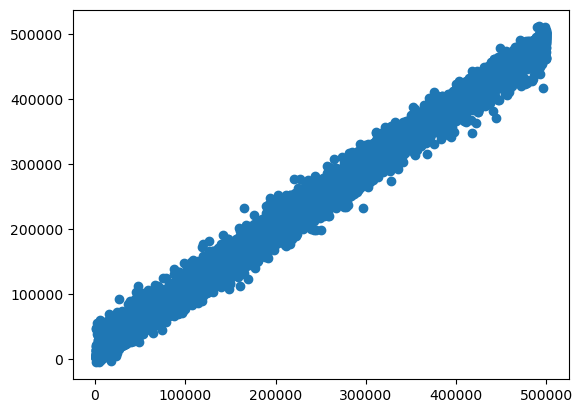

In [84]:
plt.scatter(y_train['ancestral_size']*250250, train_pred_df[1]*250250)

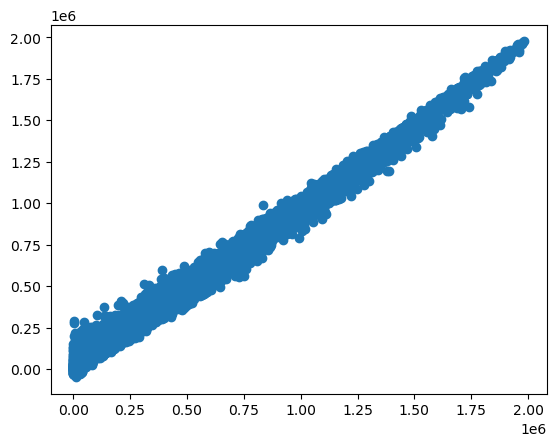

In [85]:
plt.scatter(y_train['t_change']*(2*250250), train_pred_df[0]*(2*250250))

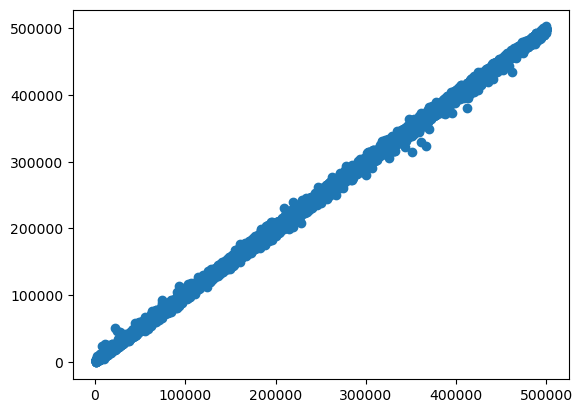

In [87]:
plt.scatter(y_train['modern_size']*(250250), train_pred_df[2]*(250250))

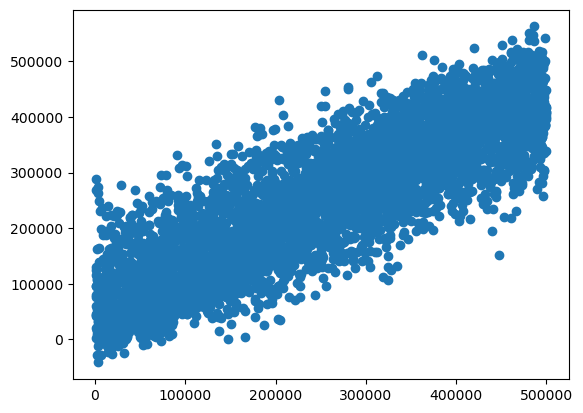

In [88]:
plt.scatter(y_test['ancestral_size']*(250250), test_pred_df[1]*(250250))

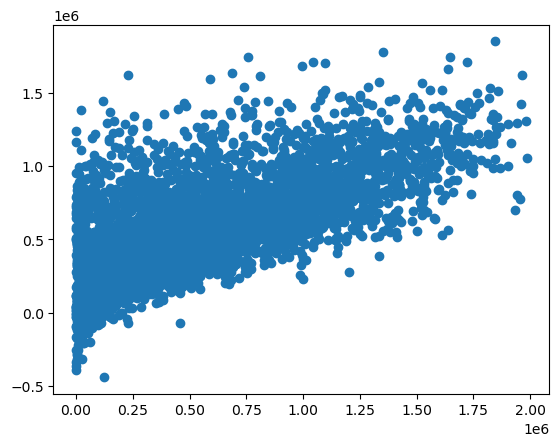

In [89]:
plt.scatter(y_test['t_change']*(2*250250), test_pred_df[0]*(2*250250))

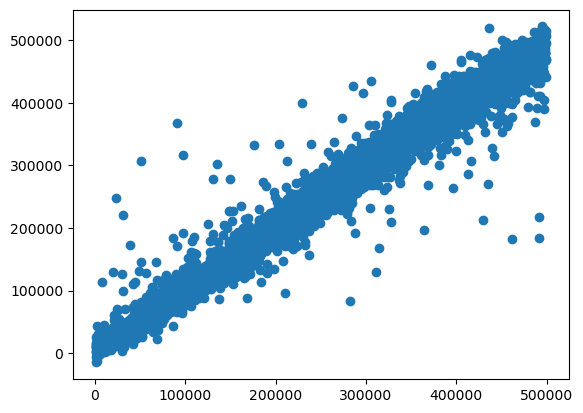

In [90]:
plt.scatter(y_test['modern_size']*(250250), test_pred_df[2]*(250250))

So now we can start tweaking our gradient boosting parameters to try and regularize our overfit model a bit.


We start out by defining a similar baseline as our 'original params' for the XGboost regressor. We then loop through a set of alternative parameterizations (along with colors and labels for plotting), refit the model, and plot.

In particular we tweak the learning rate of our model (the contribution of each tree to the final model) and the sumbsample proportion (which defines the proportion of indivudals to be sampled). Note that this technically means we're doing stochastic gradient boosting for paraemterizations with subsample < 1.0. 

No shrinkage Training MSE t change, ancestral size, modern size: [0.04012226 0.01371222 0.00107335]
No shrinkage Test MSE t change, ancestral size, modern size: [0.60375515 0.1378963  0.01816441]
Learning rate = 0.5 Training MSE t change, ancestral size, modern size: [0.06622142 0.02059111 0.00150678]
Learning rate = 0.5 Test MSE t change, ancestral size, modern size: [0.39939827 0.09264859 0.01148747]
Subsample = 0.5 Training MSE t change, ancestral size, modern size: [0.28232034 0.06795363 0.01066299]
Subsample = 0.5 Test MSE t change, ancestral size, modern size: [2.36386447 0.3231858  0.09222897]
Learning rate = 0.5, Subsample = 0.5 Training MSE t change, ancestral size, modern size: [0.10318913 0.03141777 0.00304965]
Learning rate = 0.5, Subsample = 0.5 Test MSE t change, ancestral size, modern size: [0.52552886 0.120023   0.01611687]
Subsample = 0.1 Training MSE t change, ancestral size, modern size: [0.20042996 0.05026881 0.00481598]
Subsample = 0.1 Test MSE t change, ancestral 

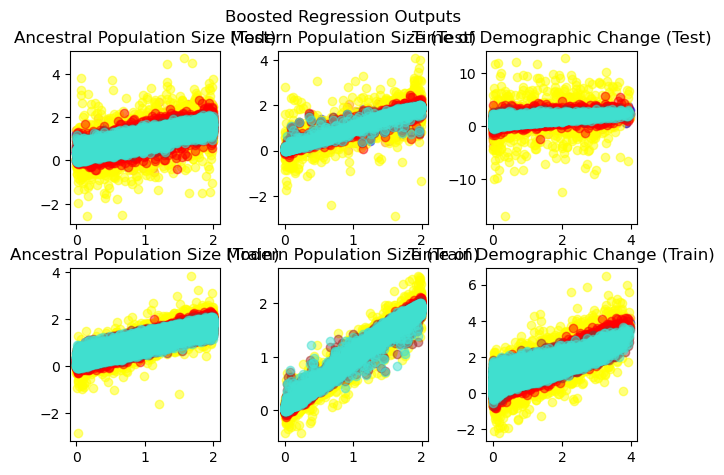

In [94]:
original_params = {
    "n_estimators": 400,
    "max_leaf_nodes": 10,
    "max_depth": None,
    "random_state": 2,
    "min_samples_split": 5,
    "max_features": None
}

fig, axs = plt.subplots(2,3)
fig.suptitle('Boosted Regression Outputs')
fig.tight_layout()
for label, color, setting in [
    ("No shrinkage", "orange", {"learning_rate": 1.0, "subsample": 1.0}),
    ("Learning rate = 0.5", "blue", {"learning_rate": 0.5, "subsample": 1.0}),
    ("Subsample = 0.5", "yellow", {"learning_rate": 1.0, "subsample":0.5}),
    ("Learning rate = 0.5, Subsample = 0.5","red", {"learning_rate":0.5, "subsample":0.5}),
    ("Subsample = 0.1","brown", {"subsample": 0.5}),
    ("Learning rate = 0.1", "turquoise", {"learning_rate": 0.1, "subsample": 1.0})
]:
    params = dict(original_params)
    params.update(setting)

    regb = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params))
    regb.fit(x_train, y_train)
    x_train_preds = regb.predict(x_train)
    x_train_df = pd.DataFrame(x_train_preds)
    print(label, 'Training MSE t change, ancestral size, modern size:', mean_squared_error(y_train, x_train_preds, multioutput='raw_values'))
    x_test_preds = regb.predict(x_test)
    x_test_df = pd.DataFrame(x_test_preds)
    print(label, 'Test MSE t change, ancestral size, modern size:', mean_squared_error(y_test, x_test_preds, multioutput='raw_values'))
    axs[0,0].scatter(
        y_test['ancestral_size'],
        x_test_df[1],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[0,0].set_title('Ancestral Population Size (Test)')
    axs[0,1].scatter(
        y_test['modern_size'],
        x_test_df[2],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[0,1].set_title('Modern Population Size (Test)')
    axs[0,2].scatter(
        y_test['t_change'],
        x_test_df[0],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[0,2].set_title('Time of Demographic Change (Test)')        
    axs[1,0].scatter(
        y_train['ancestral_size'],
        x_train_df[1],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[1,0].set_title('Ancestral Population Size (Train)')
    axs[1,1].scatter(
        y_train['modern_size'],
        x_train_df[2],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[1,1].set_title('Modern Population Size (Train)')
    axs[1,2].scatter(
        y_train['t_change'],
        x_train_df[0],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[1,2].set_title('Time of Demographic Change (Train)')
    

As we can see, in general subsampling doesn't improve our performance on the test data. At the same time, we seem to have the best improvement to test performance relative to loss of accuracy on training with a learning rate about 0.1. If we wanted to further optimize, we could do a grid search over both parameters, but for now we'll just stick with a learning rate of 0.1.

Training MSE t change, ancestral size, modern size: [0.27546943 0.06641425 0.00726478]
Test MSE t change, ancestral size, modern size: [0.33569996 0.08042692 0.01081034]


Text(0.5, 1.0, 'Time of Demographic Change (Train)')

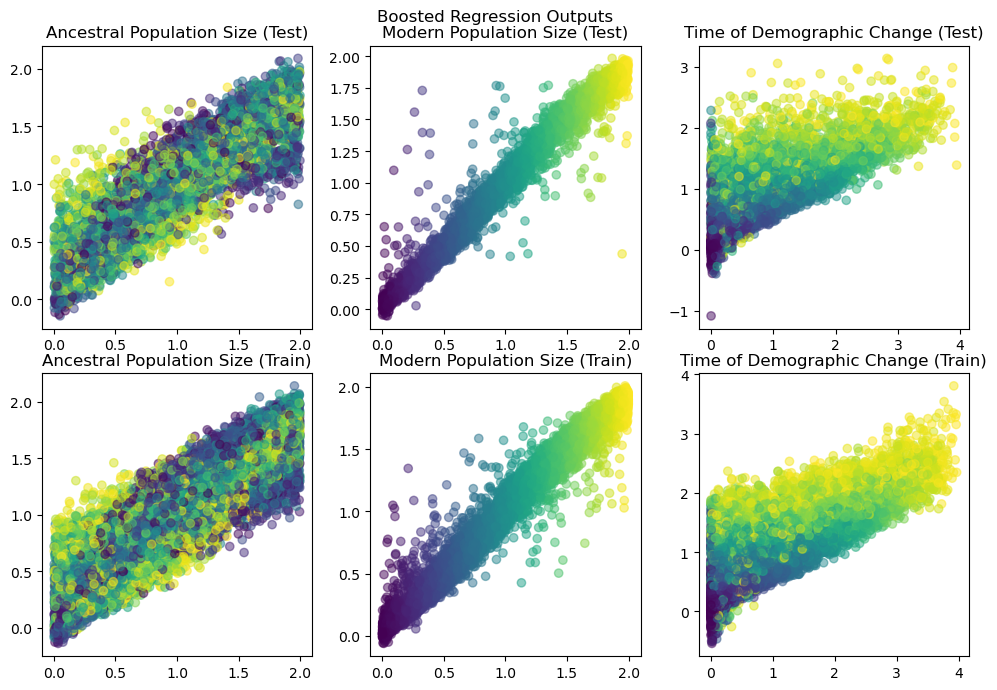

In [22]:
t_params = {
    "max_leaf_nodes": 5,
    "n_estimators": 400,
    "max_depth": None,
    "min_samples_split": 5,
    "max_features": None,
    "learning_rate": 0.1,
}


regb = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**t_params))
regb.fit(x_train, y_train)
x_train_preds = regb.predict(x_train)
x_train_df = pd.DataFrame(x_train_preds)
print('Training MSE t change, ancestral size, modern size:', mean_squared_error(y_train, x_train_preds, multioutput='raw_values'))
x_test_preds = regb.predict(x_test)
x_test_df = pd.DataFrame(x_test_preds)
print( 'Test MSE t change, ancestral size, modern size:', mean_squared_error(y_test, x_test_preds, multioutput='raw_values'))
fig, axs = plt.subplots(2,3, figsize=(10,7))
fig.suptitle('Boosted Regression Outputs')
fig.tight_layout()
axs[0,0].scatter(
    y_test['ancestral_size'],
    x_test_df[1],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,0].set_title('Ancestral Population Size (Test)')
axs[0,1].scatter(
    y_test['modern_size'],
    x_test_df[2],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,1].set_title('Modern Population Size (Test)')
axs[0,2].scatter(
    y_test['t_change'],
    x_test_df[0],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,2].set_title('Time of Demographic Change (Test)')        
axs[1,0].scatter(
    y_train['ancestral_size'],
    x_train_df[1],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,0].set_title('Ancestral Population Size (Train)')
axs[1,1].scatter(
    y_train['modern_size'],
    x_train_df[2],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,1].set_title('Modern Population Size (Train)')
axs[1,2].scatter(
    y_train['t_change'],
    x_train_df[0],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,2].set_title('Time of Demographic Change (Train)')


I've had this idea for a while now, that certain parameters of these models might be easier to estimate conditional on other parameters. E.g., large modern population sizes may show similar signatures of large ancestral populations, thus counfounding our estimates. So here I test this out with a regressor chain approach, still using gradient boosted regression trees but now estimating targets in a specific order with each sequential estimate being provided as additional input to the next estimator. So, for example, we start by estimating our modern population size from the SFS, then estimate the time of demographic change using both the SFS and the modern population size, then the ancestral population size using the SFS, the modern pop size, and the time of change. Since I have some process-based idea of why we'd expect this kind of dependence among targets, I'm only testing this order, but usually we'd test lots of different orders for the chain to see what the ideal order is.

Note that for the plots, I'm now coloring points based on the true modern population size, so we can see if there are any obvious patterns to where our larger residuals are.

Training MSE t change, ancestral size, modern size: [0.31775506 0.06737113 0.00726478]
Test MSE t change, ancestral size, modern size: [0.37213909 0.08044324 0.01083224]


Text(0.5, 1.0, 'Time of Demographic Change (Train)')

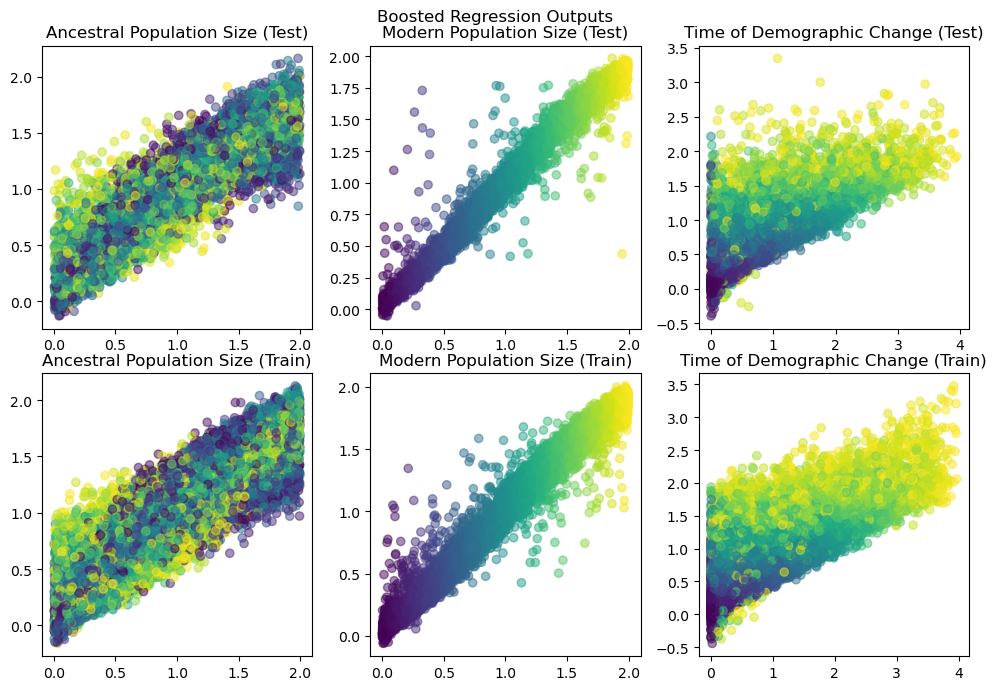

In [25]:
t_params = {
    "max_leaf_nodes": 5,
    "n_estimators": 400,
    "max_depth": None,
    "min_samples_split": 5,
    "max_features": None,
    "learning_rate": 0.1,
}


regb = RegressorChain(ensemble.GradientBoostingRegressor(**t_params), order=[2,1,0])
regb.fit(x_train, y_train)
x_train_preds = regb.predict(x_train)
x_train_df = pd.DataFrame(x_train_preds)
print('Training MSE t change, ancestral size, modern size:', mean_squared_error(y_train, x_train_preds, multioutput='raw_values'))
x_test_preds = regb.predict(x_test)
x_test_df = pd.DataFrame(x_test_preds)
print( 'Test MSE t change, ancestral size, modern size:', mean_squared_error(y_test, x_test_preds, multioutput='raw_values'))
fig, axs = plt.subplots(2,3, figsize=(10,7))
fig.suptitle('Boosted Regression Outputs')
fig.tight_layout()
axs[0,0].scatter(
    y_test['ancestral_size'],
    x_test_df[1],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,0].set_title('Ancestral Population Size (Test)')
axs[0,1].scatter(
    y_test['modern_size'],
    x_test_df[2],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,1].set_title('Modern Population Size (Test)')
axs[0,2].scatter(
    y_test['t_change'],
    x_test_df[0],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,2].set_title('Time of Demographic Change (Test)')        
axs[1,0].scatter(
    y_train['ancestral_size'],
    x_train_df[1],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,0].set_title('Ancestral Population Size (Train)')
axs[1,1].scatter(
    y_train['modern_size'],
    x_train_df[2],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,1].set_title('Modern Population Size (Train)')
axs[1,2].scatter(
    y_train['t_change'],
    x_train_df[0],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,2].set_title('Time of Demographic Change (Train)')


Text(0.5, 1.0, 'Time of Demographic Change (Train)')

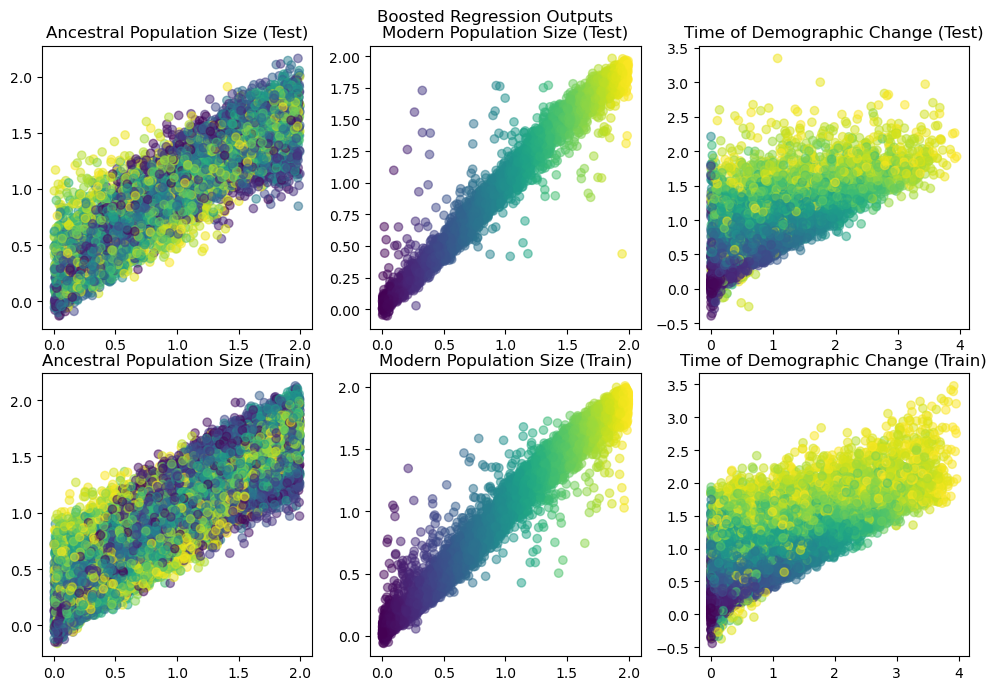

In [21]:
fig, axs = plt.subplots(2,3, figsize=(10,7))
fig.suptitle('Boosted Regression Outputs')
fig.tight_layout()
axs[0,0].scatter(
    y_test['ancestral_size'],
    x_test_df[1],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,0].set_title('Ancestral Population Size (Test)')
axs[0,1].scatter(
    y_test['modern_size'],
    x_test_df[2],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,1].set_title('Modern Population Size (Test)')
axs[0,2].scatter(
    y_test['t_change'],
    x_test_df[0],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,2].set_title('Time of Demographic Change (Test)')        
axs[1,0].scatter(
    y_train['ancestral_size'],
    x_train_df[1],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,0].set_title('Ancestral Population Size (Train)')
axs[1,1].scatter(
    y_train['modern_size'],
    x_train_df[2],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,1].set_title('Modern Population Size (Train)')
axs[1,2].scatter(
    y_train['t_change'],
    x_train_df[0],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,2].set_title('Time of Demographic Change (Train)')


No shrinkage Training MSE 0.2785558632547788
No shrinkage Test MSE 0.27992255359994456
learning_rate=0.5 Training MSE 0.2678303946691657
learning_rate=0.5 Test MSE 0.2692006694805707
learning_rate=0.25 Training MSE 0.25651539283422203
learning_rate=0.25 Test MSE 0.2597556895743019
learning_rate=0.1 Training MSE 0.26450822598491336
learning_rate=0.1 Test MSE 0.2690900976657649


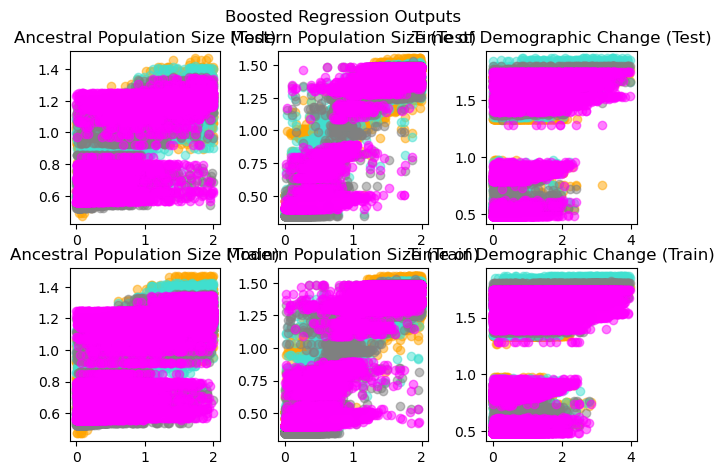

In [30]:
tree_params = {
    "max_leaf_nodes": 10,
    "max_depth": None,
    "random_state": 2,
    "min_samples_split": 5,
    "max_features": None
}
ada_params = {
    "n_estimators": 400,
    'random_state': 2,
}

fig, axs = plt.subplots(2,3)
fig.suptitle('Boosted Regression Outputs')
fig.tight_layout()
for label, color, setting in [
    ("No shrinkage", "orange", {"learning_rate": 1.0}),
    ("learning_rate=0.5", "turquoise", {"learning_rate": 0.5}),
    (
        "learning_rate=0.25",
        "gray",
        {"learning_rate": 0.25},
    ),
    ('learning_rate=0.1', 'magenta',{'learning_rate':0.1})
]:
    params = dict(ada_params)
    params.update(setting)

    regb = MultiOutputRegressor(ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor(**tree_params), **setting))
    regb.fit(x_train, y_train)

    x_train_preds = regb.predict(x_train)
    x_train_df = pd.DataFrame(x_train_preds)
    print(label, 'Training MSE', mean_squared_error(y_train, x_train_preds))
    x_test_preds = regb.predict(x_test)
    x_test_df = pd.DataFrame(x_test_preds)
    print(label, 'Test MSE', mean_squared_error(y_test, x_test_preds))
    axs[0,0].scatter(
        y_test['ancestral_size'],
        x_test_df[1],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[0,0].set_title('Ancestral Population Size (Test)')
    axs[0,1].scatter(
        y_test['modern_size'],
        x_test_df[2],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[0,1].set_title('Modern Population Size (Test)')
    axs[0,2].scatter(
        y_test['t_change'],
        x_test_df[0],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[0,2].set_title('Time of Demographic Change (Test)')        
    axs[1,0].scatter(
        y_train['ancestral_size'],
        x_train_df[1],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[1,0].set_title('Ancestral Population Size (Train)')
    axs[1,1].scatter(
        y_train['modern_size'],
        x_train_df[2],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[1,1].set_title('Modern Population Size (Train)')
    axs[1,2].scatter(
        y_train['t_change'],
        x_train_df[0],
        color=color,
        label=label,
        alpha=0.5
    )
    axs[1,2].set_title('Time of Demographic Change (Train)')
    

<bound method BaseEstimator.get_params of MultiOutputRegressor(estimator=AdaBoostRegressor(estimator=GradientBoostingRegressor(max_depth=None,
                                                                                     max_leaf_nodes=4,
                                                                                     min_samples_split=5,
                                                                                     n_estimators=400,
                                                                                     random_state=2,
                                                                                     subsample=0.4)))>

In [2]:
e3_test = pd.read_csv('/Users/aaronw/Desktop/Dissertation/Chapter_5_Diascia/DL_popgen/Detectability_tests/Shared_data_repo/Benchmarking/Empirical_run/Marginal_locus_run/3e_n20_marginal_params.csv')
#path for 
#big_test = pd.read_csv('/scratch/alpine/aawe2235/Fall_2022_Diascia/DL_demo/Detectability_tests/Shared_data_repo/Benchmarking/single_bottleneck_params.csv')

#big_test['training_labels'] = np.random.permutation(big_test['training_labels'].values)
x3_dat = []
for f in e3_test['n20_path']:
    x3_dat.append(pd.read_csv(f)['SFS'])


#x_dat.head
#x_df = pd.DataFrame(x_dat)
#x_df.head
x3_df = pd.DataFrame(x3_dat)
x3_df[40] = e3_test['num_loci'].values
y3_dat = e3_test[['t_mod', 't_mid', 'ancestral_size', 'mid_size','modern_size']]
scale3_vals = [2*250250, 2*250250, 250250, 250250, 250250]
y3_scaled = y3_dat/scale3_vals
x3_train, x3_test, y3_train, y3_test = train_test_split(x3_df, y3_scaled)





In [3]:
y3_test.columns

Index(['t_mod', 't_mid', 'ancestral_size', 'mid_size', 'modern_size'], dtype='object')

In [ ]:
gb_params = {
    "n_estimators": 400,
    "max_leaf_nodes": 5,
    "max_depth": None,
    "min_samples_split": 5,
    "max_features": None,
    "learning_rate": 0.1
}
gb = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**gb_params))
gb.fit(x3_train, y3_train)



In [ ]:
x3_test_preds = gb.predict(x3_test)
x3_test_df = pd.DataFrame(x3_test_preds)
x3_train_preds = gb.predict(x3_train)
x3_train_df = pd.DataFrame(x3_train_preds)
fig, axs = plt.subplots(2,5)
fig.suptitle('Boosted Regression Outputs')
fig.tight_layout()
print('Training MSE t mod, t mid, ancestral size, mid size, modern size:', mean_squared_error(y3_train, x3_train_preds, multioutput='raw_values'))
#rcx3_test_preds = rc_gb.predict(x3_test)
#rcx3_test_df = pd.DataFrame(rcx3_test_preds)
print( 'Test MSE t mod, t mid, ancestral size, mid size, modern size:', mean_squared_error(y3_test, x3_test_preds, multioutput='raw_values'))
#Index(['t_mod', 't_mid', 'ancestral_size', 'mid_size', 'modern_size'], dtype='object')
axs[0,0].scatter(
    y3_test['ancestral_size'*250250],
    x3_test_df[2]*250250,
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,0].set_title('Ancestral Population Size (Test)',size = 6)
axs[0,1].scatter(
    y3_test['modern_size']*250250,
    x3_test_df[4]*250250,
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,1].set_title('Modern Population Size (Test)',size = 6)
axs[0,2].scatter(
    y3_test['t_mod']*(2*250250),
    x3_test_df[0]*(2*250250),
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,2].set_title('Time of Modern Change (Test)',size = 6)        

axs[0,3].scatter(
    y3_test['t_mid']*(2*250250),
    x3_test_df[1]*(2*250250),
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,3].set_title('Time of Mid Change (Test)',size = 6)  

axs[0,4].scatter(
    y3_test['mid_size']*250250,
    x3_test_df[3]*250250,
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,4].set_title('Mid Population Size (Test)',size = 6)  


axs[1,0].scatter(
    y3_train['ancestral_size']*250250,
    x3_train_df[2]*250250,
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,0].set_title('Ancestral Population Size (Train)',size = 6)
axs[1,1].scatter(
    y3_train['modern_size']*250250,
    x3_train_df[4]*250250,
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,1].set_title('Modern Population Size (Train)',size = 6)
axs[1,2].scatter(
    y3_train['t_mod']*(2*250250),
    x3_train_df[0]*(2*250250),
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,2].set_title('Time of Modern Change (Train)',size = 6)        

axs[1,3].scatter(
    y3_train['t_mid']*(2*250250),
    x3_train_df[1]*(2*250250),
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,3].set_title('Time of Mid Change (Train)',size = 6)  

axs[1,4].scatter(
    y3_train['mid_size']*250250,
    x3_train_df[3]*250250,
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,4].set_title('Mid Population Size (Train)',size = 6)  


Training MSE t mod, t mid, ancestral size, mid size, modern size: [0.27747488 0.56703452 0.2347441  0.21160912 0.00750375]
Test MSE t mod, t mid, ancestral size, mid size, modern size: [0.33954907 0.65033243 0.26231987 0.23667257 0.01083603]


Text(0.5, 1.0, 'Mid Population Size (Train)')

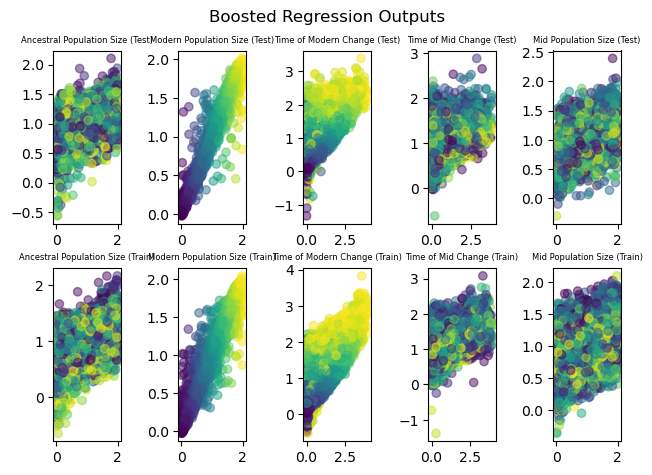

In [4]:
reg_chain_params = {
    "n_estimators": 400,
    "max_leaf_nodes": 5,
    "max_depth": None,
    "min_samples_split": 5,
    "max_features": None,
    "learning_rate": 0.1
}
rc_gb = RegressorChain(ensemble.GradientBoostingRegressor(**reg_chain_params), order=[4,0,3,1,2])
rc_gb.fit(x3_train, y3_train)
rcx3_test_preds = rc_gb.predict(x3_test)
rcx3_test_df = pd.DataFrame(rcx3_test_preds)
rcx3_train_preds = rc_gb.predict(x3_train)
rcx3_train_df = pd.DataFrame(rcx3_train_preds)
fig, axs = plt.subplots(2,5)
fig.suptitle('Boosted Regression Outputs')
fig.tight_layout()
print('Training MSE t mod, t mid, ancestral size, mid size, modern size:', mean_squared_error(y3_train, rcx3_train_preds, multioutput='raw_values'))
#rcx3_test_preds = rc_gb.predict(x3_test)
#rcx3_test_df = pd.DataFrame(rcx3_test_preds)
print( 'Test MSE t mod, t mid, ancestral size, mid size, modern size:', mean_squared_error(y3_test, rcx3_test_preds, multioutput='raw_values'))
#Index(['t_mod', 't_mid', 'ancestral_size', 'mid_size', 'modern_size'], dtype='object')
axs[0,0].scatter(
    y3_test['ancestral_size'],
    rcx3_test_df[2],
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,0].set_title('Ancestral Population Size (Test)',size = 6)
axs[0,1].scatter(
    y3_test['modern_size'],
    rcx3_test_df[4],
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,1].set_title('Modern Population Size (Test)',size = 6)
axs[0,2].scatter(
    y3_test['t_mod'],
    rcx3_test_df[0],
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,2].set_title('Time of Modern Change (Test)',size = 6)        

axs[0,3].scatter(
    y3_test['t_mid'],
    rcx3_test_df[1],
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,3].set_title('Time of Mid Change (Test)',size = 6)  

axs[0,4].scatter(
    y3_test['mid_size'],
    rcx3_test_df[3],
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,4].set_title('Mid Population Size (Test)',size = 6)  


axs[1,0].scatter(
    y3_train['ancestral_size'],
    rcx3_train_df[2],
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,0].set_title('Ancestral Population Size (Train)',size = 6)
axs[1,1].scatter(
    y3_train['modern_size'],
    rcx3_train_df[4],
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,1].set_title('Modern Population Size (Train)',size = 6)
axs[1,2].scatter(
    y3_train['t_mod'],
    rcx3_train_df[0],
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,2].set_title('Time of Modern Change (Train)',size = 6)        

axs[1,3].scatter(
    y3_train['t_mid'],
    rcx3_train_df[1],
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,3].set_title('Time of Mid Change (Train)',size = 6)  

axs[1,4].scatter(
    y3_train['mid_size'],
    rcx3_train_df[3],
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,4].set_title('Mid Population Size (Train)',size = 6)  



Training MSE t mod, t mid, ancestral size, mid size, modern size: [0.27747488 0.56703452 0.2347441  0.21160912 0.00750375]
Test MSE t mod, t mid, ancestral size, mid size, modern size: [0.33954907 0.65033243 0.26231987 0.23667257 0.01083603]


Text(0.5, 1.0, 'Mid Population Size (Train)')

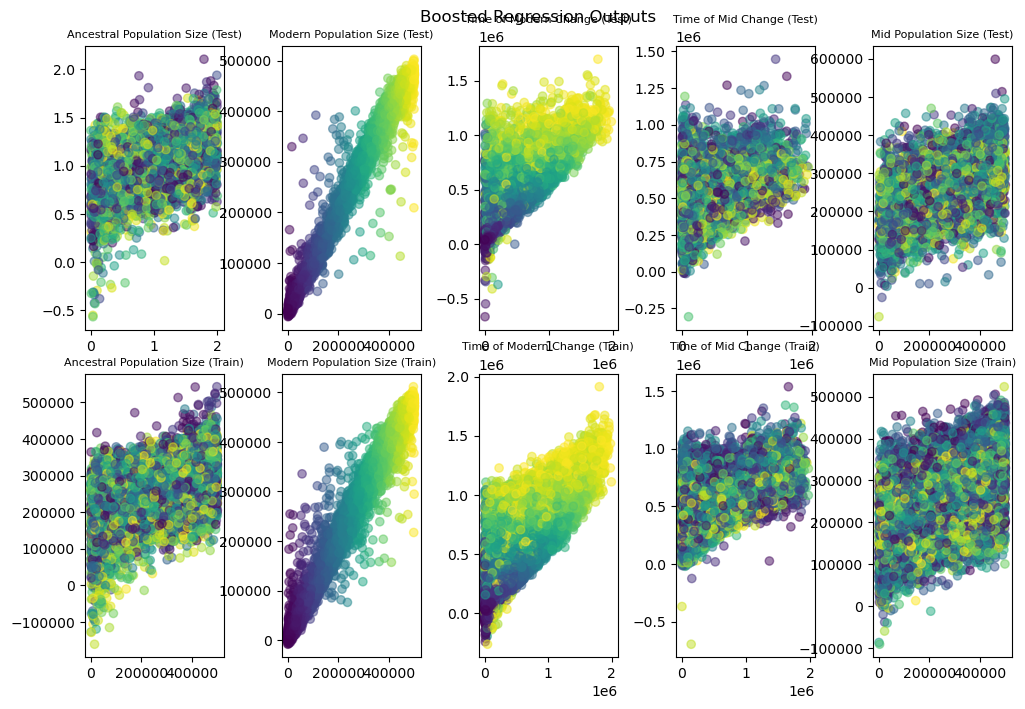

In [29]:
fig, axs = plt.subplots(2,5, figsize=(10,7))
fig.suptitle('Boosted Regression Outputs')
fig.tight_layout()
print('Training MSE t mod, t mid, ancestral size, mid size, modern size:', mean_squared_error(y3_train, rcx3_train_preds, multioutput='raw_values'))
#rcx3_test_preds = rc_gb.predict(x3_test)
#rcx3_test_df = pd.DataFrame(rcx3_test_preds)
print( 'Test MSE t mod, t mid, ancestral size, mid size, modern size:', mean_squared_error(y3_test, rcx3_test_preds, multioutput='raw_values'))
#Index(['t_mod', 't_mid', 'ancestral_size', 'mid_size', 'modern_size'], dtype='object')
axs[0,0].scatter(
    y3_test['ancestral_size'],
    rcx3_test_df[2],
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,0].set_title('Ancestral Population Size (Test)',size = 8)
axs[0,1].scatter(
    y3_test['modern_size']*250250,
    rcx3_test_df[4]*250250,
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,1].set_title('Modern Population Size (Test)',size = 8)
axs[0,2].scatter(
    y3_test['t_mod']*(2*250250),
    rcx3_test_df[0]*(2*250250),
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,2].set_title('Time of Modern Change (Test)',size = 8)        

axs[0,3].scatter(
    y3_test['t_mid']*(2*250250),
    rcx3_test_df[1]*(2*250250),
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,3].set_title('Time of Mid Change (Test)',size = 8)  

axs[0,4].scatter(
    y3_test['mid_size']*250250,
    rcx3_test_df[3]*250250,
    c=y3_test['modern_size'],
    alpha=0.5
)
axs[0,4].set_title('Mid Population Size (Test)',size = 8)  


axs[1,0].scatter(
    y3_train['ancestral_size']*250250,
    rcx3_train_df[2]*250250,
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,0].set_title('Ancestral Population Size (Train)',size = 8)
axs[1,1].scatter(
    y3_train['modern_size']*250250,
    rcx3_train_df[4]*250250,
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,1].set_title('Modern Population Size (Train)',size = 8)
axs[1,2].scatter(
    y3_train['t_mod']*(2*250250),
    rcx3_train_df[0]*(2*250250),
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,2].set_title('Time of Modern Change (Train)',size = 8)        

axs[1,3].scatter(
    y3_train['t_mid']*(2*250250),
    rcx3_train_df[1]*(2*250250),
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,3].set_title('Time of Mid Change (Train)',size = 8)  

axs[1,4].scatter(
    y3_train['mid_size']*250250,
    rcx3_train_df[3]*250250,
    c=y3_train['modern_size'],
    alpha=0.5
)
axs[1,4].set_title('Mid Population Size (Train)',size = 8)  


In [43]:
lr = LinearRegression()
lr.fit(rcx3_test_df[4].values.reshape(-1,1), y3_test['modern_size'])

LinearRegression()

In [45]:
lr.score(rcx3_test_df[4].values.reshape(-1,1), y3_test['modern_size'])
lr.coef_

array([1.00203127])

NameError: name 'x_test_df' is not defined

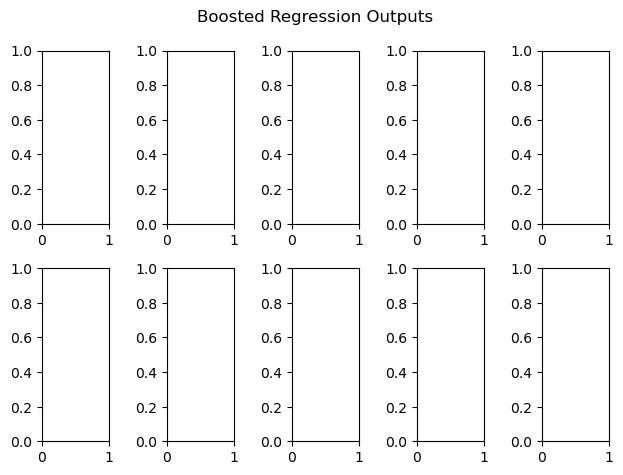

In [15]:
fig, axs = plt.subplots(2,5)
fig.suptitle('Boosted Regression Outputs')
fig.tight_layout()
axs[0,0].scatter(
    y_test['ancestral_size'],
    x_test_df[2],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,0].set_title('Ancestral Population Size (Test)', size=6)
axs[0,1].scatter(
    y_test['modern_size'],
    x_test_df[4],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,1].set_title('Modern Population Size (Test)', size=6)
axs[0,2].scatter(
    y_test['t_mod'],
    x_test_df[0],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,2].set_title('Time of Modern Change (Test)', size=6)        

axs[0,3].scatter(
    y_test['t_mid'],
    x_test_df[1],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,3].set_title('Time of Mid Change (Test)', size=6)  

axs[0,4].scatter(
    y_test['mid_size'],
    x_test_df[3],
    c=y_test['modern_size'],
    alpha=0.5
)
axs[0,4].set_title('Mid Population Size (Test)', size=6)  


axs[1,0].scatter(
    y_train['ancestral_size'],
    x_train_df[2],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,0].set_title('Ancestral Population Size (Train)', size=6)
axs[1,1].scatter(
    y_train['modern_size'],
    x_train_df[4],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,1].set_title('Modern Population Size (Train)', size=6)
axs[1,2].scatter(
    y_train['t_mod'],
    x_train_df[0],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,2].set_title('Time of Modern Change (Train)', size=6)        

axs[1,3].scatter(
    y_train['t_mid'],
    x_train_df[1],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,3].set_title('Time of Mid Change (Train)', size=6)  

axs[1,4].scatter(
    y_train['mid_size'],
    x_train_df[3],
    c=y_train['modern_size'],
    alpha=0.5
)
axs[1,4].set_title('Mid Population Size (Train)', size=6)  


In [ ]:
original_params = {
    "n_estimators": 400,
    "max_leaf_nodes": 4,
    "max_depth": None,
    "random_state": 2,
    "min_samples_split": 5,
    "max_features": None
}


for label, color, setting in [
    ("No shrinkage", "orange", {"learning_rate": 1.0, "subsample": 1.0}),
    ("learning_rate=0.2", "turquoise", {"learning_rate": 0.2, "subsample": 1.0}),
    ("subsample=0.5", "blue", {"learning_rate": 1.0, "subsample": 0.5}),
    (
        "learning_rate=0.2, subsample=0.5",
        "gray",
        {"learning_rate": 0.2, "subsample": 0.5},
    ),
    ('learning_rate=0.1, subsample=0.4', 'magenta',{'learning_rate':0.1, 'subsample':0.4})
]:
    params = dict(original_params)
    params.update(setting)

    regb = RegressorChain(ensemble.GradientBoostingRegressor(**params), order=[4,0,3,1,2)
    regb.fit(x3_train, y3_train)

    # compute test set deviance
    #test_deviance = np.zeros((params["n_estimators"],), dtype=np.float64)

    x_test_preds = regb.predict(x3_test)
    x_test_df = pd.DataFrame(x3_test_preds)
    print(mean_squared_error(y3_test, x3_test_preds))
    plt.scatter(
        y3_test['mid_size'],
        x3_test_df[3],
        color=color,
        label=label,
        alpha=0.5
    )